## Import modules and functions

In [1]:
import numpy as np
import os
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_scalebar.scalebar import ScaleBar
import scipy.ndimage as ndi
from skimage.filters import rank 
from scipy.signal import butter, lfilter
import scipy.misc as misc
from skimage import exposure
from PIL import Image
import colorcet as cc
from scipy.misc import toimage
import matplotlib.colors as clr
import pandas as pd
import seaborn as sns
from scipy import stats
import cv2
from pyspark import SparkContext, SparkConf
import skimage
from pathlib import Path

def mean2(x):
    y = np.sum(x) / np.size(x);
    return y
def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / np.sqrt((a*a).sum() * (b*b).sum());
    return r
from copy import deepcopy
from skimage.filters import threshold_otsu,threshold_li
import glob
from IPython.display import clear_output
import scipy.io as spio

## Define directory of images

In [2]:
expdir='/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed culture/Controls/20200312_TNRin_vs_out/' #master folder

## Make dictionary for storing results

In [7]:
results = {"filename":[],"exp":[],"coverslip":[],
           "Manual mask from matlab GUI":[],"bg sub int under mask":[],"bg sub int after under mask":[],
          "no before pxl":[],"no after pxl":[]}
path = os.path.dirname(expdir)  
outputFolder = os.path.dirname(expdir + "/new/")
filelist = []
for root, _, filenames in os.walk(path):
     for filename in filenames:
         filelist.append(os.path.join(root, filename))      
for i in range(0,len(filelist)):
    #if "analyse" in str(filelist[i]):
        if ("ignore" in str(filelist[i]))==False:
            if filelist[i].endswith(".tif"): 
                results["filename"].append(filelist[i])
                results["coverslip"].append(filelist[i].split('/')[-2])
                results["exp"].append(filelist[i].split('/')[-4])

## Read manual masks from Matlab GUI

In [8]:
## matlab files
for im in range(0,len(results["filename"])): 
    file=results["filename"][im][:-4]+'_dendritesmask.mat'
    from pathlib import Path
    my_file = Path(file)
    if my_file.exists():
        print(file)
        mat = spio.loadmat(file, squeeze_me=True)
        mask=mat['totMask']>0.99
        results["Manual mask from matlab GUI"].append(mask)
    else:
        results["Manual mask from matlab GUI"].append(np.nan)
clear_output()        
print("Done!")

Done!


## Batch analysis of images - mean intensity

In [10]:
import pims


print('Total number of images: ' + str(len(results['filename'])))

for i in range(0,len(results["filename"])): 
    flag=False
    print('Calculating image no ' + str(i+1) + ' out of' + str(len(results["filename"])))
    #read the image
    
    full_image=pims.open(results["filename"][i])
    ecm_image=full_image[0]
    ecm_image_after=full_image[1]
    
    #convert to numpy array - a format easier to manipunuclei with code
    
    #read masks 
    matlab_mask=results["Manual mask from matlab GUI"][i]
    if type(matlab_mask)==np.ndarray:
        flag=True
    #image after background subtraction
    #for ecm image
    if flag==True:
        ecm_matlabmasked_bgreduced=deepcopy(ecm_image)
        bg_matlabmask=np.mean(ndi.median_filter(ecm_image[matlab_mask],size=5))+0*np.std(ndi.median_filter(ecm_image[matlab_mask],size=5))
        ecm_matlabmasked_bgreduced=np.subtract(ecm_matlabmasked_bgreduced,bg_matlabmask)
        ecm_matlabmasked_bgreduced[ecm_matlabmasked_bgreduced<0]=0
        ecm_matlabmasked_bgreduced[~matlab_mask]=0
        results["bg sub int under mask"].append(ecm_matlabmasked_bgreduced[matlab_mask].mean())
        no=np.sum(ecm_matlabmasked_bgreduced>0)
        results["no before pxl"].append(no)
        
        ecm_matlabmasked_bgreduced=deepcopy(ecm_image_after)
        bg_matlabmask=np.mean(ndi.median_filter(ecm_image_after[matlab_mask],size=5))+0*np.std(ndi.median_filter(ecm_image_after[matlab_mask],size=5))
        ecm_matlabmasked_bgreduced=np.subtract(ecm_matlabmasked_bgreduced,bg_matlabmask)
        ecm_matlabmasked_bgreduced[ecm_matlabmasked_bgreduced<0]=0
        ecm_matlabmasked_bgreduced[~matlab_mask]=0
        results["bg sub int after under mask"].append(ecm_matlabmasked_bgreduced[matlab_mask].mean())
        no=np.sum(ecm_matlabmasked_bgreduced>0)
        results["no after pxl"].append(no)
    
    else:
        results["bg sub int under mask"].append(np.nan)
        results["bg sub int after under mask"].append(np.nan)
        results["no after pxl"].append(np.nan)
        results["no before pxl"].append(np.nan)

Total number of images: 30
Calculating image no 1 out of30


NameError: name 'ecm_image_after' is not defined

## Make a dataframe of the results

In [45]:
df=pd.DataFrame(results)
df2=deepcopy(df)
df2['Exp']='20x'
df2.loc[df2['filename'].str.contains('100x'), 'Exp'] = '100x'

[]

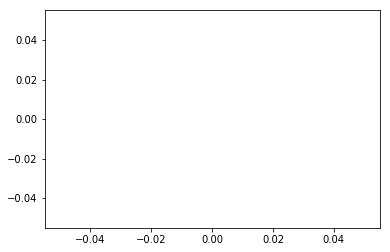

In [50]:
df20=df2[df2["Exp"]=="20x"]
plt.plot(y=[df20["bg sub int under mask"].values,df20["bg sub int after under mask"].values])

Calculating image no 1 out of20
Calculating image no 2 out of20
Calculating image no 3 out of20
Calculating image no 4 out of20
Calculating image no 5 out of20
Calculating image no 6 out of20
Calculating image no 7 out of20
Calculating image no 8 out of20
Calculating image no 9 out of20
Calculating image no 10 out of20
Calculating image no 11 out of20


/Users/taldankovich/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Calculating image no 12 out of20
Calculating image no 13 out of20
Calculating image no 14 out of20
Calculating image no 15 out of20
Calculating image no 16 out of20
Calculating image no 17 out of20
Calculating image no 18 out of20
Calculating image no 19 out of20
Calculating image no 20 out of20


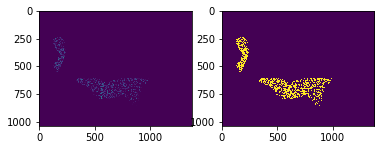

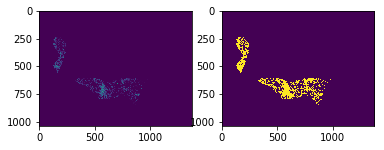

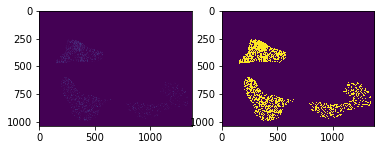

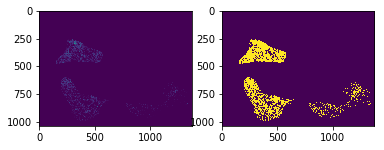

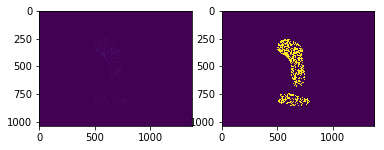

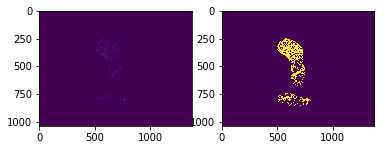

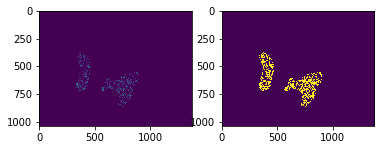

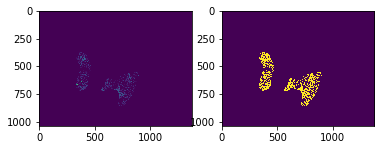

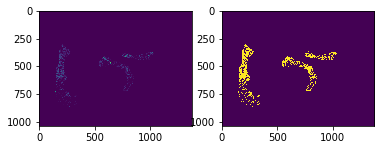

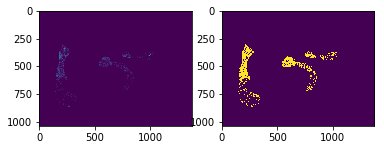

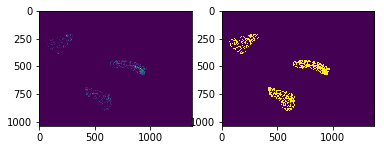

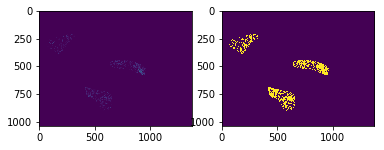

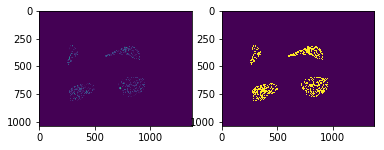

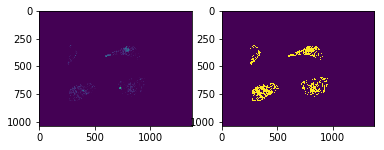

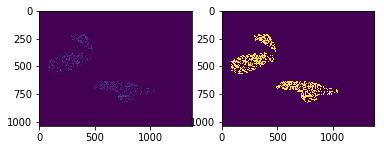

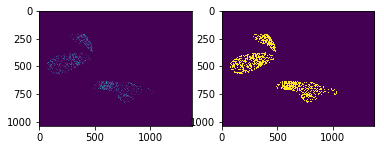

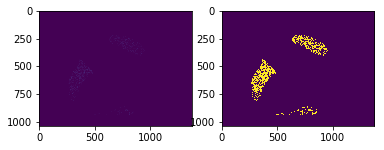

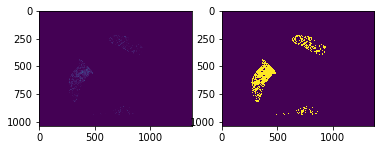

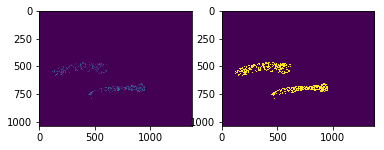

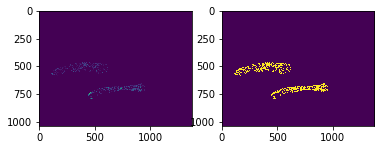

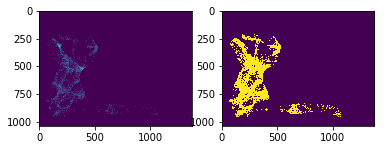

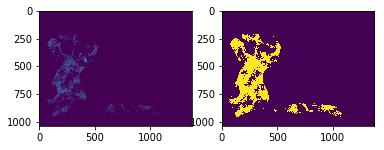

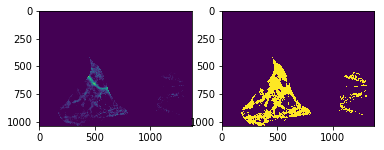

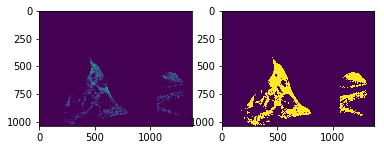

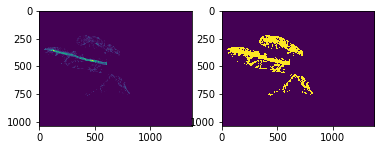

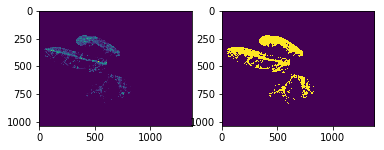

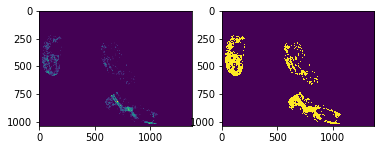

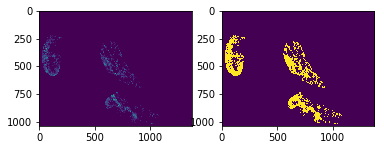

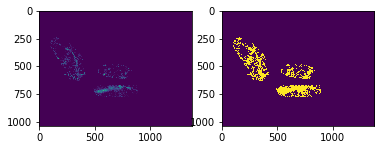

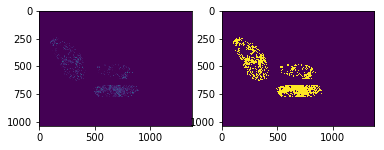

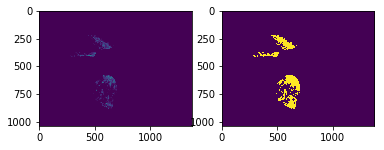

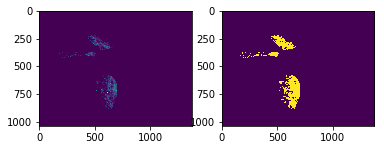

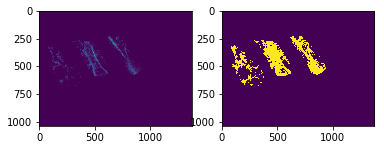

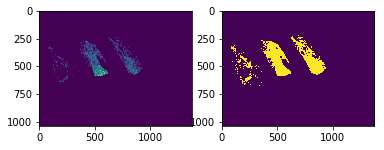

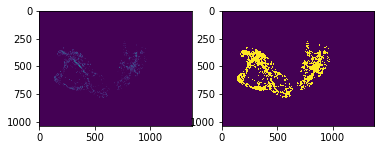

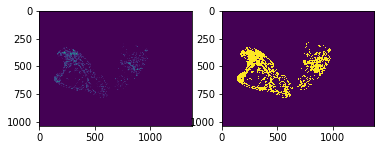

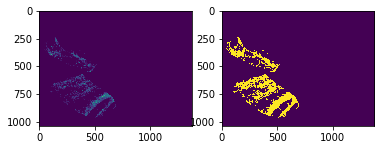

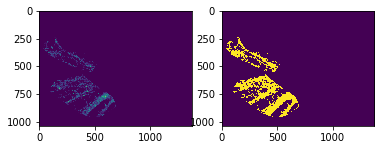

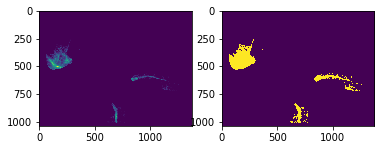

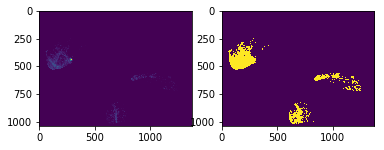

In [56]:
for i in range(0,len(results["filename"])): 
    flag=False
    print('Calculating image no ' + str(i+1) + ' out of' + str(len(results["filename"])))
    #read the image
    matlab_mask=results["Manual mask from matlab GUI"][i]
    full_image=pims.open(results["filename"][i])
    ecm_image=full_image[0]
    
    ecm_matlabmasked_bgreduced=deepcopy(ecm_image)
    bg_matlabmask=np.mean(ndi.median_filter(ecm_image[matlab_mask],size=5))+0*np.std(ndi.median_filter(ecm_image[matlab_mask],size=5))
    ecm_matlabmasked_bgreduced=np.subtract(ecm_matlabmasked_bgreduced,bg_matlabmask)
    ecm_matlabmasked_bgreduced[ecm_matlabmasked_bgreduced<0]=0
    ecm_matlabmasked_bgreduced[~matlab_mask]=0
    ecm_binary=ecm_matlabmasked_bgreduced>0
    
    fig=plt.figure()
    fig.add_subplot(121)
    plt.imshow(ecm_matlabmasked_bgreduced)
    fig.add_subplot(122)
    plt.imshow(ecm_binary)
    
    ecm_image=full_image[1]
    
    ecm_matlabmasked_bgreduced=deepcopy(ecm_image)
    bg_matlabmask=np.mean(ndi.median_filter(ecm_image[matlab_mask],size=5))+0*np.std(ndi.median_filter(ecm_image[matlab_mask],size=5))
    ecm_matlabmasked_bgreduced=np.subtract(ecm_matlabmasked_bgreduced,bg_matlabmask)
    ecm_matlabmasked_bgreduced[ecm_matlabmasked_bgreduced<0]=0
    ecm_matlabmasked_bgreduced[~matlab_mask]=0
    ecm_binary=ecm_matlabmasked_bgreduced>0
    
    fig=plt.figure()
    fig.add_subplot(121)
    plt.imshow(ecm_matlabmasked_bgreduced)
    fig.add_subplot(122)
    plt.imshow(ecm_binary)
    
   
    
    

In [57]:
df20["no before pxl"].values

array([ 55821, 104956,  42158,  42118,  43536,  38716,  42832,  58874,
        46680,  34050])

In [58]:
df20["no after pxl"].values

array([ 55715, 106516,  41221,  41145,  43808,  40370,  40637,  59742,
        45361,  33386])

In [32]:
df20["bg sub int after under mask"].values.mean()

69.56076929595244

In [26]:
day0=dfmeans[dfmeans["Day"]=="0"][var].values
day1=dfmeans[dfmeans["Day"]=="1"][var].values
day3=dfmeans[dfmeans["Day"]=="3"][var].values

[stat1,pval1]=stats.ttest_rel(day0,day1)
[stat3,pval3]=stats.ttest_rel(day0,day3)

print(pval1)
print(pval3)



0.14091785662339315
0.056768325955436315


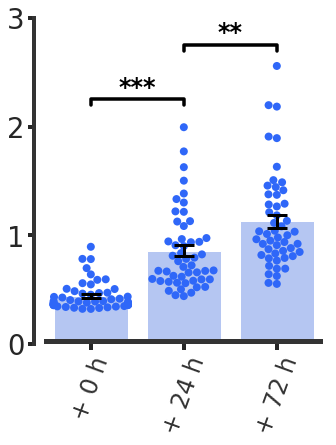

In [27]:
sns.set(font_scale=2.5)
sns.set_style("ticks")
sns.set_palette("Set2")
from matplotlib import ticker


var="bg sub int under mask"


fig=plt.figure(figsize=(5,6))

order=["0","1","3"]



g=sns.barplot(data=df2,y=var,x="Day",
            order=order,color="#abc2fc",ci=None)

g=sns.swarmplot(data=df2,y=var,x="Day",
            order=order,color="#2F67F8",size=8)

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        # we change the bar width
        patch.set_width(new_value)
        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)
change_width(g, .8)

plt.errorbar(x=np.arange(0,len(order)),
             y=[df2[df2["Day"]==condtype][var].mean() for condtype in order],
             yerr=[df2[df2["Day"]==condtype][var].sem() for condtype in order],
             xerr=None,ecolor='black',fmt='none',capsize=10,linewidth=3,
             capthick=3,zorder=10,
            alpha=1)
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.ylim(0,300)
scale_x=100
ticks_y=ticker.FuncFormatter(lambda x, pos: '{0:g}' .format(x/scale_x))
g=plt.gca()
g.yaxis.set_major_formatter(ticks_y)

plt.axhline(0, color='#333333',alpha=1,linewidth=10)
plt.xticks(g.get_xticks(),['+ 0 h','+ 24 h','+ 72 h'],color='#333333',size=28)
g.xaxis.set_tick_params(width=4)
g.yaxis.set_tick_params(width=4)
plt.rcParams['font.sans-serif'] = 'Helvetica'
for axis in ['top','bottom','left','right']:
  g.spines[axis].set_linewidth(4)
  g.spines[axis].set_color('#333333')
  g.spines[axis].set_alpha(1)
offsets={"left":10,"bottom":0}
trims={"left":True,"bottom":False,"right":False}
sns.despine(ax=g,right=True,top=True,bottom=True,trim=trims,offset=offsets)
g.set_ylabel('')
g.set_xlabel('',color='#333333',alpha=.7)
plt.xticks(g.get_xticks(),
          rotation=70,size=24)
g.grid(False)

x1, x2 = 0,1
y= 220
h=5
col='black'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3.5, c=col)
plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col,size=24, weight='bold')

x1, x2 = 1,2
y= 270
h=5
col='black'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3.5, c=col)
plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col,size=24, weight='bold')

diri="/Volumes/Macintosh HD/Users/taldankovich/Downloads/figures/"

fig.savefig(diri+'supp_fabs_resurfacing_.svg', bbox_inches='tight', format='svg')

In [28]:
day0=df2[df2["Day"]=="0"][var].values
day1=df2[df2["Day"]=="1"][var].values
day3=df2[df2["Day"]=="3"][var].values

[stat1,pval1]=stats.ttest_ind(day0,day1)
[stat3,pval3]=stats.ttest_ind(day1,day3)

print(pval1*2)
print(pval3*2)


2.5643850043453175e-11
0.0019205546352723732


In [29]:
len(day0)

50

In [30]:
len(day1)

50

In [31]:
len(day3)

50

## find representative pics

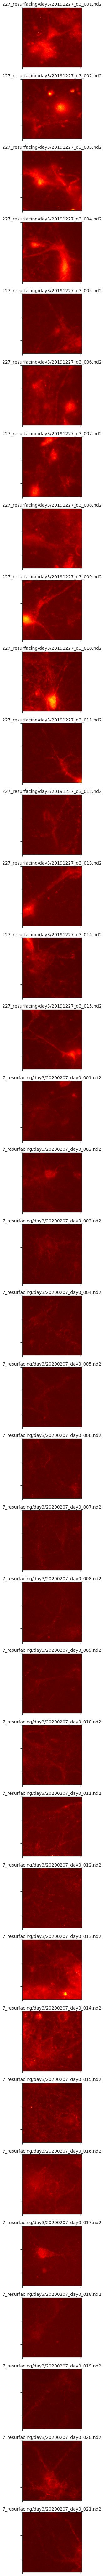

In [103]:

df_pic=df2

df0=df_pic[df_pic["Day"]=="0"]
df1=df_pic[df_pic["Day"]=="1"]
df3=df_pic[df_pic["Day"]=="3"]


df_2show=df3
df_2show=df_2show.reset_index(drop=True)

minval=0
maxval=10000
num=1
leng=len(df_2show)
fig=plt.figure(figsize=(20,150))
for i in range(0,len(df_2show)):
    #print(i)
    fig.add_subplot(leng,1,num)
    with ND2Reader(df_2show["filename"][i]) as images:
        ecm_image=images[0]
        plt.imshow(ecm_image,interpolation='none',cmap='hot',vmin=minval,vmax=maxval)
        plt.title(df_2show["filename"][i][-40:], size=14)
        plt.yticks(visible=False)
        plt.xticks(visible=False)
        plt.grid(visible=False)
        plt.axis(visible=False)
        #scalebar = ScaleBar(107.1, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
        #                       font_properties={'size':0,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
        #plt.gca().add_artist(scalebar)
        num+=1
    

In [21]:
df2.head()

,filename,exp,coverslip,Manual mask from matlab GUI,bg sub int under mask,Day,Exp,bg sub int under mask norm2med
